#**Analyzing gene expression differences and annotating cell clusters**

Here, we have cells grouped into clusters and will try to understand what differentiates each cluster from other cells in the dataset and classify the clusters based on their cell types.

There are several ways to achieve this objective:

* One approach is to identify marker genes that are significantly upregulated in the cell types of interest compared to the rest of the dataset.
* Another method involves comparing the entire gene expression profiles between different groups or clusters.
* Alternatively, automated methods can be employed to compare cells of interest with databases of cell type expression profiles, which combines clustering and annotation.
* While automated methods show promise, they are not yet able to fully replace human curation, which remains essential for accurate annotations.

In the case of well-defined cell types, we expect marker genes to exhibit substantial differences in expression between the cell type of interest and the rest of the dataset, enabling us to utilize simpler methods. This approach will be the main focus of our analysis.

### Installations

In [3]:
!pip install -q scanpy

import scanpy as sc
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from matplotlib import pyplot as plt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 40.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.2 MB/s eta 0:00:00


In [4]:
# magic incantation to help matplotlib work with our jupyter notebook
%matplotlib inline

### Load Data

I uploaded the raw file on my drive. This is the [LINK](https://drive.google.com/file/d/1IcuPPI67ExanZQfihZR3RzzpHqMeDm4_/view?usp=sharing) if you want to download the file.

Now, we will read the date from Drive.

In [30]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [35]:
adata = sc.read('/content/gdrive/MyDrive/Colab Notebooks/Bioinfo/mouse_brain_clusters.h5ad')
raw = pd.DataFrame(data=adata.X, index=adata.obs_names, columns=adata.var_names)

In [36]:
adata

AnnData object with n_obs × n_vars = 3210 × 18585
    obs: 'cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id', 'plate.barcode', 'n_genes', 'n_counts', 'kmeans', 'louvain'
    var: 'ERCC', 'n_cells', 'n_counts', 'mean', 'std'
    uns: 'cell_ontology_class_colors', 'kmeans_colors', 'louvain', 'louvain_colors', 'mouse.id_colors', 'neighbors', 'pca', 'plate.barcode_colors', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [38]:
print(raw.shape)
raw.head()

(3210, 18585)


,0610005C13Rik,0610007C21Rik,0610007L01Rik,0610007N19Rik,0610007P08Rik,0610007P14Rik,0610007P22Rik,0610009B14Rik,0610009B22Rik,0610009D07Rik,...,Zwint,Zxda,Zxdb,Zxdc,Zyg11b,Zyx,Zzef1,Zzz3,a,l7Rn6
cell,,,,,,,,,,,,,,,,,,,,,
A1.B003290.3_38_F.1.1,-0.080923,0.785535,1.334149,-0.27278,-0.415238,-0.830928,-0.469169,-0.031466,-0.603434,-1.021057,...,-0.722872,-0.214449,-0.1927,-0.416267,-0.59249,-0.591548,-0.553282,-0.565488,-0.043849,1.567807
A1.B003728.3_56_F.1.1,-0.080923,-1.484576,-0.576335,-0.27278,-0.415238,1.835243,-0.469169,-0.031466,-0.603434,-1.021057,...,-0.722872,-0.214449,-0.1927,-0.416267,-0.59249,-0.591548,-0.553282,-0.565488,-0.043849,-0.681190
A1.MAA000560.3_10_M.1.1,-0.080923,0.629806,-0.576335,-0.27278,-0.415238,-0.208355,-0.469169,-0.031466,-0.603434,1.252464,...,1.315405,-0.214449,-0.1927,-0.416267,-0.59249,-0.591548,2.073000,-0.565488,-0.043849,1.259893
A1.MAA000564.3_10_M.1.1,-0.080923,0.380935,1.782380,-0.27278,-0.415238,1.030647,-0.469169,-0.031466,1.263194,-1.021057,...,-0.722872,-0.214449,-0.1927,-0.416267,-0.59249,2.389810,-0.553282,0.169718,-0.043849,-0.681190
A1.MAA000923.3_9_M.1.1,-0.080923,0.565247,-0.576335,-0.27278,-0.415238,-0.830928,-0.469169,-0.031466,-0.603434,-1.021057,...,-0.722872,-0.214449,-0.1927,-0.416267,2.31862,-0.591548,-0.553282,-0.565488,-0.043849,-0.681190


#**Comparing distributions**

* Differential expression algorithms encompass various methodologies for comparing the gene expression distribution between two distinct groups.
* In single-cell experiments, unlike bulk RNA-seq, we typically have a substantial number of samples (cells) for each group being compared.
* This abundance of data allows us to leverage the complete distribution of expression values within each group, enabling us to detect differences between groups beyond just comparing mean expression estimates, which is the standard practice in bulk RNA-seq.

###**Developing understanding**
To better comprehend the concept, let's revisit some fundamental statistical principles.

In this case, we are interested in a specific cluster and aim to ascertain whether it consists of astrocytes. To begin, we will create a plot depicting the distribution of expression for a marker gene in the cluster and compare it to the rest of the dataset.

In [39]:
adata.obs.cell_ontology_class.unique()

['astrocyte', 'oligodendrocyte', 'endothelial cell', 'neuron', 'oligodendrocyte precursor cell', 'Bergmann glial cell', 'brain pericyte']
Categories (7, object): ['Bergmann glial cell', 'astrocyte', 'brain pericyte', 'endothelial cell', 'neuron',
                         'oligodendrocyte', 'oligodendrocyte precursor cell']

In [40]:
print(adata.obs.columns)

Index(['cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id',
       'plate.barcode', 'n_genes', 'n_counts', 'kmeans', 'louvain'],
      dtype='object')


In [41]:
astrocyte_marker = 'Gja1' # define genes of interest
# housekeeping = 'Chmp2a'

cluster2 = raw[adata.obs['louvain'] == '2'] # Use a mask to subset dataset to cells assigned to cluster 2
not_cluster2 = raw[adata.obs['louvain'] != '2'] # All other cells

In [42]:
cluster2.head()  # Dataframe containing cells belonging to cluster 2

,0610005C13Rik,0610007C21Rik,0610007L01Rik,0610007N19Rik,0610007P08Rik,0610007P14Rik,0610007P22Rik,0610009B14Rik,0610009B22Rik,0610009D07Rik,...,Zwint,Zxda,Zxdb,Zxdc,Zyg11b,Zyx,Zzef1,Zzz3,a,l7Rn6
cell,,,,,,,,,,,,,,,,,,,,,
A1.B003290.3_38_F.1.1,-0.080923,0.785535,1.334149,-0.27278,-0.415238,-0.830928,-0.469169,-0.031466,-0.603434,-1.021057,...,-0.722872,-0.214449,-0.1927,-0.416267,-0.592490,-0.591548,-0.553282,-0.565488,-0.043849,1.567807
A1.B003728.3_56_F.1.1,-0.080923,-1.484576,-0.576335,-0.27278,-0.415238,1.835243,-0.469169,-0.031466,-0.603434,-1.021057,...,-0.722872,-0.214449,-0.1927,-0.416267,-0.592490,-0.591548,-0.553282,-0.565488,-0.043849,-0.681190
A1.MAA000923.3_9_M.1.1,-0.080923,0.565247,-0.576335,-0.27278,-0.415238,-0.830928,-0.469169,-0.031466,-0.603434,-1.021057,...,-0.722872,-0.214449,-0.1927,-0.416267,2.318620,-0.591548,-0.553282,-0.565488,-0.043849,-0.681190
A1.MAA000930.3_8_M.1.1,-0.080923,-1.484576,-0.576335,-0.27278,-0.415238,-0.830928,-0.469169,-0.031466,-0.603434,1.962481,...,-0.722872,-0.214449,-0.1927,-0.416267,0.351834,-0.591548,-0.553282,-0.565488,-0.043849,-0.681190
A10.MAA000926.3_9_M.1.1,-0.080923,0.621897,-0.576335,-0.27278,-0.415238,-0.830928,0.977147,-0.031466,-0.603434,-1.021057,...,-0.722872,-0.214449,-0.1927,-0.416267,-0.592490,-0.591548,2.060564,2.555042,-0.043849,1.734757


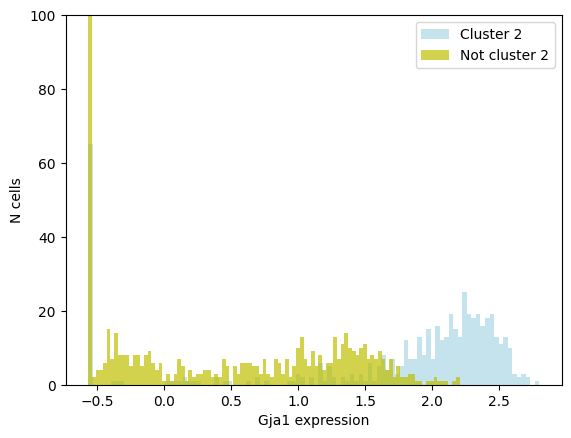

In [44]:
cluster2_marker_exp = cluster2[astrocyte_marker]  # getting the values for all cells of cluster 2 for the specific gene
plt.hist(cluster2_marker_exp.values, bins=100, color='lightblue', alpha=0.7, label='Cluster 2') # Plot distribution

not_cluster2_marker_exp = not_cluster2[astrocyte_marker]  # # getting the values for all cells not belonging to cluster 2 for the specific gene
plt.hist(not_cluster2_marker_exp, bins=100, color='y', alpha=0.7, label='Not cluster 2')

plt.ylim(0,100) # Cut off at N=100 for visual clarity
plt.xlabel('%s expression'%astrocyte_marker) # label our axes
plt.ylabel('N cells')
plt.legend()

**These two distributions suggest:**
- Cells in this **cluster express more of the marker gene than other cells** in the dataset.
- However, we also see that these distributions overlap: **Some cells in the cluster don't express the gene at all, and some cells outside the cluster express it relatively highly.**

Therefore, to determine whether this cluster is exhibiting "_differential expression_" of our marker gene, we will use simple **hypothesis testing methods**. Since marker genes are expected to show significant differences in expression, we can calculate the probability (**p-value**) of observing such a level of differential expression if all these cells were part of the same population (i.e. if the null hypothesis was true).

### T-test
A t-test is used to compare our data with the **null hypothesis**, which assumes that the means of two distributions are **equal**. It takes into account the mean, standard deviation, and sample size of both distributions.

However, relying solely on the p-value does not provide information about the magnitude of the difference. When dealing with large sample sizes (N), even very small differences in expression values (which may not be biologically significant) can lead to "statistically significant" p-values.

In [45]:
from scipy.stats import ttest_ind

ttest = ttest_ind(cluster2_marker_exp,
          not_cluster2_marker_exp,
          equal_var=False, # it's not necessarily fair to assume that these two populations have equal variance
          nan_policy='omit') # omit NaN values
print(ttest)

Ttest_indResult(statistic=43.63423462375544, pvalue=4.850451754546287e-185)


* This finding indicates that the likelihood of these two populations having no true difference in mean expression is quite low, considering the observed sample.
* Importantly, even though a significant number of cells in this cluster express the marker gene, there are also a considerable number of cells that do not. Hence, caution is needed before assuming that a cluster corresponds directly to a specific cell type.



- **Scanpy has a very useful function for repeating this process of subsetting the dataset to one group and comparing it to the rest of the dataset.**
- It then **returns the genes that are most differentially expressed between that group and all others**. Let's look at the genes that are most cell-type specific.

#### Computing differential expression vai using "cell_ontology_class


**Scanpy** provides a highly valuable function to simplify the process of subsetting the dataset into one group and comparing it against the rest of the dataset.

This function identifies and presents the genes that exhibit the most significant differential expression between the selected group and all other groups.

Let's explore the genes that show the highest cell-type specificity.

/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:418: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: invalid value encountered in true_divide
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:418: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: invalid value encoun

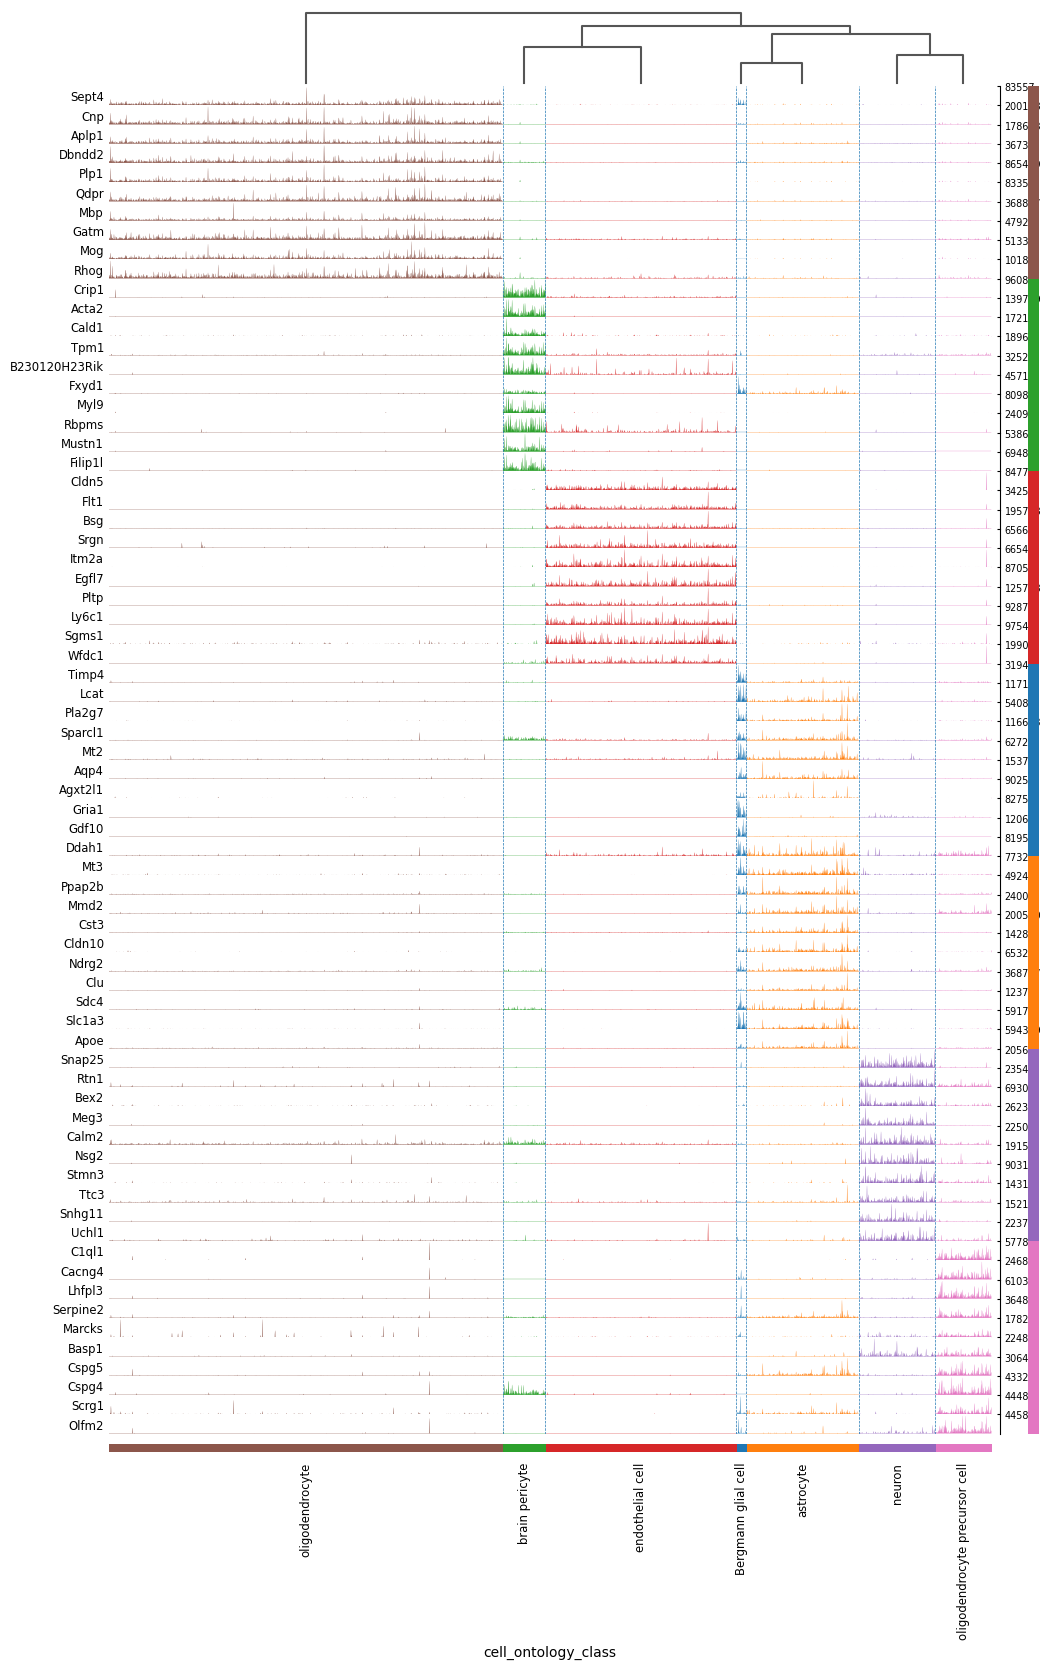

In [46]:
# Rank genes for characterizing groups
sc.tl.rank_genes_groups(adata, groupby='cell_ontology_class', use_raw=True,
                        method='t-test_overestim_var', n_genes=10) # compute differential expression
# The key of the observations grouping to consider.-> "cell_ontology_class"
sc.pl.rank_genes_groups_tracksplot(adata, groupby='cell_ontology_class')  # Plot ranking of genes using heatmap plot (

In [47]:
adata

AnnData object with n_obs × n_vars = 3210 × 18585
    obs: 'cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id', 'plate.barcode', 'n_genes', 'n_counts', 'kmeans', 'louvain'
    var: 'ERCC', 'n_cells', 'n_counts', 'mean', 'std'
    uns: 'cell_ontology_class_colors', 'kmeans_colors', 'louvain', 'louvain_colors', 'mouse.id_colors', 'neighbors', 'pca', 'plate.barcode_colors', 'tsne', 'umap', 'rank_genes_groups', 'dendrogram_cell_ontology_class'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

#### Computing differential expression vai using "louvain" clusters

/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:418: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: invalid value encountered in true_divide
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:418: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: invalid value encoun

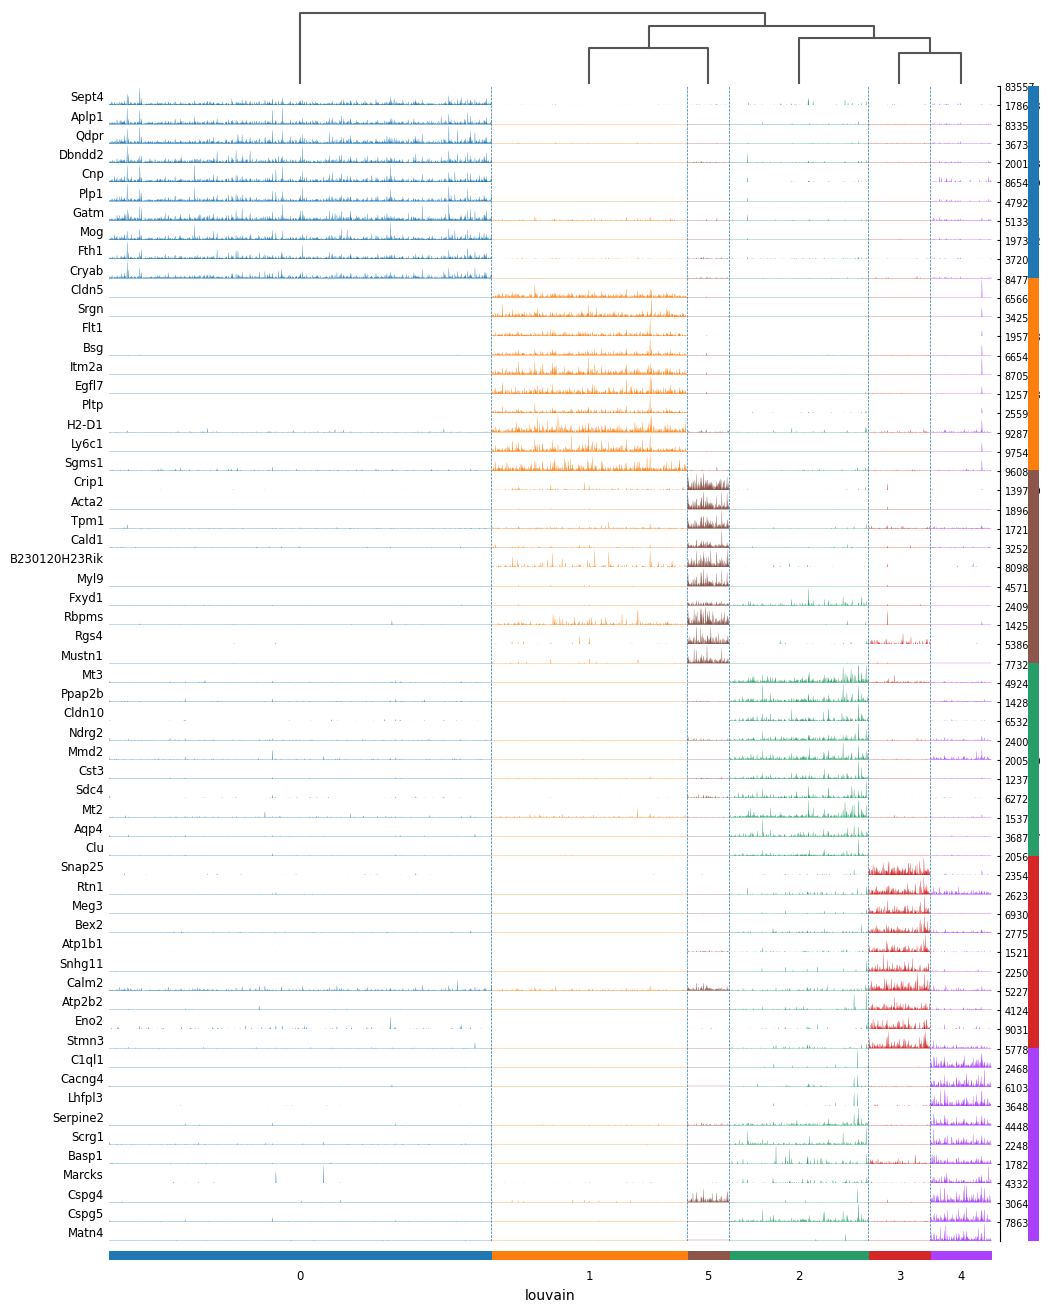

In [48]:
sc.tl.rank_genes_groups(adata, groupby='louvain', use_raw=True,
                        method='t-test_overestim_var', n_genes=10) # compute differential expression
sc.pl.rank_genes_groups_tracksplot(adata, groupby='louvain') # Plot ranking of genes using heatmap plot (

###**Assessing against established marker genes.**

We can also compare these marker genes identified through data analysis to the well-established and commonly recognized genes that have long been known as reliable indicators of specific cell types in the field.

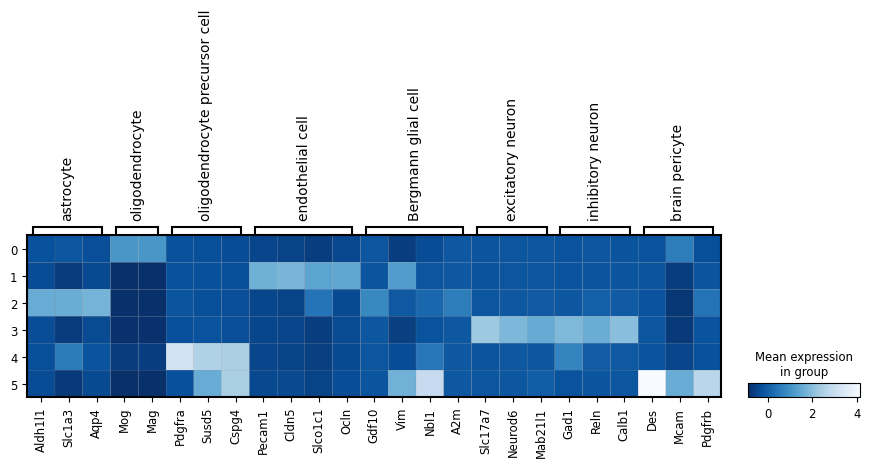

In [56]:
marker_genes = {
'astrocyte': ['Aldh1l1', 'Slc1a3', 'Aqp4'],
'oligodendrocyte': ['Mog','Mag'],
'oligodendrocyte precursor cell': ['Pdgfra','Susd5','Cspg4'],
'endothelial cell': ['Pecam1','Cldn5','Slco1c1','Ocln'],
'Bergmann glial cell': ['Gdf10','Vim','Nbl1','A2m'],
'excitatory neuron': ['Slc17a7','Neurod6','Mab21l1'],
'inhibitory neuron': ['Gad1','Reln','Calb1'],
'brain pericyte': ['Des','Mcam','Pdgfrb']
}

sc.pl.matrixplot(adata, marker_genes, groupby='louvain', use_raw=False, cmap='Blues_r')